# Variational Quantum Eigensolver

A common application of the Variational Quantum Eigensolver (VQE) algorithm is to compute the ground state energy of a molecular system. The code below demonstrates how to perform classical preprocessing for a $H_2$ molecule (i.e. obtain the integrals from a Hartree-Fock computation to build the molecular Hamiltonian), prepare the initial Hartree-Fock state on the quantum register, add the parameterized UCCSD ansatz to the kernel, and select the COBYLA optimizer.  We are then ready to call `cudaq:vqe` to estimate the minimum energy of the system.

In [1]:
# pip install openfermionpyscf

In [2]:
import cudaq

cudaq.set_target("nvidia", option="fp64")

The problem of interest here is a chain of hydrogen atoms seperated along the z-axis at a fixed interval called the bond distance.

The interatomic electrostatic forces due to the electrons and protons and the shielding by the neutrons creates a chemical system whose energy can be minimised to find a stable configuration.

Let us first begin by defining the molecule and other metadata about the problem.


In [3]:
import cudaq
import openfermion
import openfermionpyscf
from openfermion.transforms import jordan_wigner, get_fermion_operator

# Number of hydrogen atoms.
hydrogen_count = 2

# Distance between the atoms in Angstroms.
bond_distance = 0.7474

# Define a linear chain of Hydrogen atoms
geometry = [("H", (0, 0, i * bond_distance)) for i in range(hydrogen_count)]

basis = "sto3g"
multiplicity = 1
charge = 0

molecule = openfermionpyscf.run_pyscf(openfermion.MolecularData(geometry, basis, multiplicity, charge))
molecular_hamiltonian = molecule.get_molecular_hamiltonian()
fermion_hamiltonian = get_fermion_operator(molecular_hamiltonian)
qubit_hamiltonian = jordan_wigner(fermion_hamiltonian)

spin_operator = cudaq.SpinOperator(qubit_hamiltonian)

num_qubits = spin_operator.get_qubit_count()
electron_count = molecule.n_electrons

/opt/nvidia/cudaq/cudaq/operator/definitions.py:241: ComplexWarning: Casting complex values to real discards the imaginary part
  cudaq_runtime.SpinOperator(*args, **kwargs))


In [4]:
## Classical solution
import numpy as np

matrix = np.array(spin_operator.to_matrix())
print("Ground state energy:", np.linalg.eigvalsh(matrix)[0])

Ground state energy: -1.1371757102406845


We now generate a Unitary Coupled-Cluster Singles and Doubles (UCCSD) ansatz from the template provided by CUDA-Q.  

In [5]:
@cudaq.kernel
def kernel(thetas: list[float]):

    qubits = cudaq.qvector(num_qubits)

    for i in range(electron_count):
        x(qubits[i])

    cudaq.kernels.uccsd(qubits, thetas, electron_count, num_qubits)


parameter_count = cudaq.kernels.uccsd_num_parameters(electron_count, num_qubits)

In [6]:
parameter_count

3

### Using CUDA-Q Optimizers

We use the builtin optimizers within CUDA-Q for the minimization procedure.

In [7]:
optimizer = cudaq.optimizers.COBYLA()

energy, parameters = cudaq.vqe(kernel, spin_operator, optimizer, parameter_count=parameter_count)

print(energy)

-1.1371756649403284


### Integration with Third-Party Optimizers

We can also integrate popular libraries like scipy with CUDA-Q.

In [8]:
from scipy.optimize import minimize


# Define a function to minimize
def cost(theta):

    exp_val = cudaq.observe(kernel, spin_operator, theta).expectation()

    return exp_val


exp_vals = []


def callback(xk):
    exp_vals.append(cost(xk))


# Initial variational parameters.
np.random.seed(42)
x0 = np.random.normal(0, np.pi, parameter_count)

# Use the scipy optimizer to minimize the function of interest
result = minimize(cost, x0, method="COBYLA", callback=callback, options={"maxiter": 40})

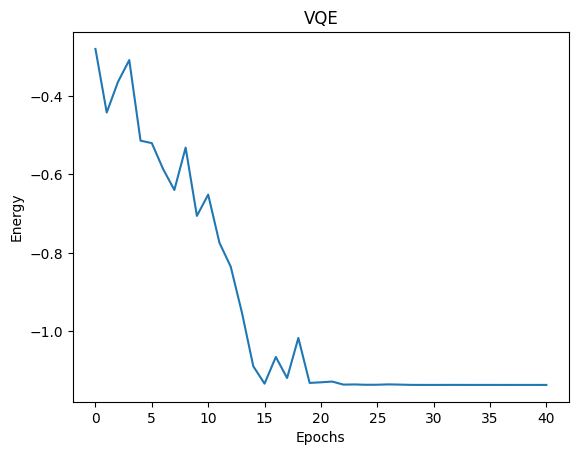

In [9]:
import matplotlib.pyplot as plt

plt.plot(exp_vals)
plt.xlabel("Epochs")
plt.ylabel("Energy")
plt.title("VQE")
plt.show()

In [10]:
print("Ground state energy:", np.linalg.eigvalsh(matrix)[0])
print("Final energy", exp_vals[-1])

Ground state energy: -1.1371757102406845
Final energy -1.137173755080864


<div class="alert alert-block alert-success">

## Exercise

Let’s try increasing the number of hydrogen atoms to more than two, like `4` or `6`. Run the variational quantum eigensolver and try other optimizers and/or ansatz.
</div>

In [11]:
# Write your codes here

In [12]:
print(cudaq.__version__)

CUDA-Q Version cu11-0.10.0 (https://github.com/NVIDIA/cuda-quantum 857dd2ce0a783c32416af8fba8664ff30f9ddc47)
